### This notebook provides some examples of use of ConCF.

In [1]:
from Utils.model import SingleCF, ConCF
from Utils.utils import *
from Utils.train import train, train_singleCF

import torch
import torch.optim as optim
import torch.utils.data as data

import random
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## 0. Loading Dataset & Setting Hyperparameters

The hyperparameters can be further tuned to achieve higher performance.

In [3]:
# setup
gpu = torch.device('cuda:' + str(0))
user_num, item_num, train_R, train_inter, valid_R, test_R = load_data()

# Loader
train_dataset = OCCF_train_dataset(user_num, item_num, train_R, train_inter)
train_loader = data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataset = OCCF_test_dataset(user_num, item_num, valid_R, test_R)

train_dict = {'max_epoch': 200, 'train_loader': train_loader, 'lr':0.01, 'alpha':0.005, 'weight_decay':1e-5, 'dim':64}
test_dict = {'test_dataset': test_dataset}

## 1. Training
### a. SingleCF (CF-A)

In [4]:
model = SingleCF(user_num, item_num, train_dict['dim'], gpu).to(gpu)
optimizer = optim.Adam(model.parameters(), lr=train_dict['lr'], weight_decay=train_dict['weight_decay'])
SingleCF_hist_R, SingleCF_hist_N = train_singleCF(model, gpu, optimizer, train_dict, test_dict)

### b. ConCF

In [5]:
model = ConCF(user_num, item_num, train_dict['dim'], gpu).to(gpu)
optimizer = optim.Adam(model.parameters(), lr=train_dict['lr'], weight_decay=train_dict['weight_decay'])
ConCF_A_hist_R, ConCF_C_hist_R, ConCF_A_hist_N, ConCF_C_hist_N = train(model, gpu, optimizer, train_dict, test_dict)

### c. ConCF (without the consensus learning)

In [6]:
model = ConCF(user_num, item_num, train_dict['dim'], gpu).to(gpu)
optimizer = optim.Adam(model.parameters(), lr=train_dict['lr'], weight_decay=train_dict['weight_decay'])
train_dict['alpha'] = 0.
ConCF_A_hist_R2, _, ConCF_A_hist_N2, _ = train(model, gpu, optimizer, train_dict, test_dict)

## 2. Training Schemes comparison

### a. SingleCF vs. ConCF

- The performance of the head trained by CF-A is significantly improved in ConCF
- The consensus collaboratively evolves with the heads based on their complementarity, providing accurate supervision.

Text(2, 0.196, 'Consensus Learning Start')

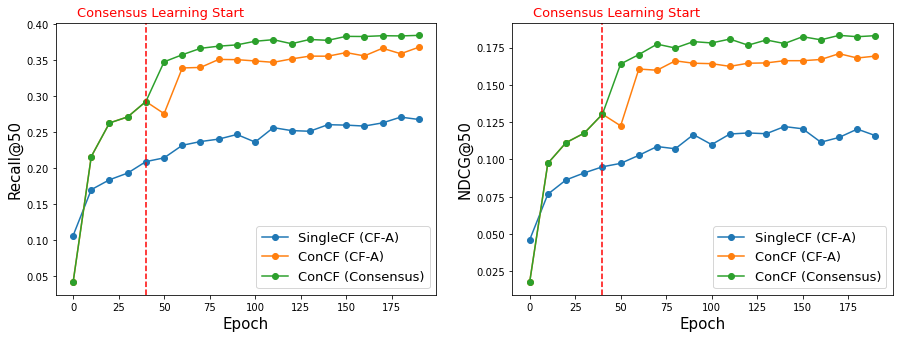

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
x = [i for i in range(0, 200, 10)]

axes[0].plot(x, SingleCF_hist_R, label='SingleCF (CF-A)', marker='o')
axes[0].plot(x, ConCF_A_hist_R, label='ConCF (CF-A)', marker='o')
axes[0].plot(x, ConCF_C_hist_R, label='ConCF (Consensus)', marker='o')

axes[0].axvline(x=40, color='red', linestyle='--')
axes[0].legend(loc=4, fontsize=13)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_ylabel('Recall@50', fontsize=15)
axes[0].text(2, 0.41, 'Consensus Learning Start', fontsize=13, color='red')

axes[1].plot(x, SingleCF_hist_N, label='SingleCF (CF-A)', marker='o')
axes[1].plot(x, ConCF_A_hist_N, label='ConCF (CF-A)', marker='o')
axes[1].plot(x, ConCF_C_hist_N, label='ConCF (Consensus)', marker='o')

axes[1].axvline(x=40, color='red', linestyle='--')
axes[1].legend(loc=4, fontsize=13)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_ylabel('NDCG@50', fontsize=15)
axes[1].text(2, 0.196, 'Consensus Learning Start', fontsize=13, color='red')

### b. ConCF (w/o CL) vs. ConCF

- ConCF (w/o CL) cannot effectively improve the performance of each head.

Text(2, 0.184, 'Consensus Learning Start')

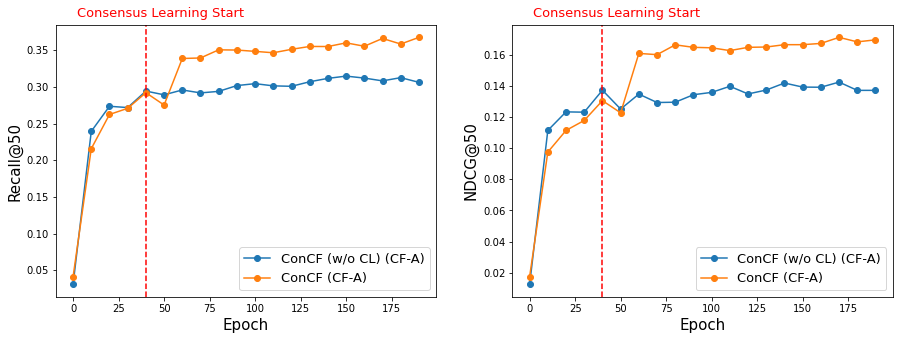

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
x = [i for i in range(0, 200, 10)]

axes[0].plot(x, ConCF_A_hist_R2, label='ConCF (w/o CL) (CF-A)', marker='o')
axes[0].plot(x, ConCF_A_hist_R, label='ConCF (CF-A)', marker='o')

axes[0].axvline(x=40, color='red', linestyle='--')
axes[0].legend(loc=4, fontsize=13)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_ylabel('Recall@50', fontsize=15)
axes[0].text(2, 0.395, 'Consensus Learning Start', fontsize=13, color='red')

axes[1].plot(x, ConCF_A_hist_N2, label='ConCF (w/o CL) (CF-A)', marker='o')
axes[1].plot(x, ConCF_A_hist_N, label='ConCF (CF-A)', marker='o')

axes[1].axvline(x=40, color='red', linestyle='--')
axes[1].legend(loc=4, fontsize=13)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_ylabel('NDCG@50', fontsize=15)
axes[1].text(2, 0.184, 'Consensus Learning Start', fontsize=13, color='red')